# Анализ результатов тестирования изменений, связанных с внедрением улучшенной рекомендательной системы
<a id='beginning'></a>

[`Ссылка на проект (ipynb)`](https://disk.yandex.ru/d/07xHzGz_QmDBPw)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-и-предобработка-данных" data-toc-modified-id="Загрузка-и-предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и предобработка данных</a></span></li><li><span><a href="#Оценка-корректности-проведения-теста" data-toc-modified-id="Оценка-корректности-проведения-теста-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Оценка корректности проведения теста</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Оценка-результатов-A/B-тестирования" data-toc-modified-id="Оценка-результатов-A/B-тестирования-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Оценка результатов A/B тестирования</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Описание проекта
[`Перейти к содержанию проекта`](#beginning)

**Цель исследования**    

Оценить корректность проведения теста, связанного с внедрением улучшенной рекомендательной системы, и проанализировать его результаты.

В процессе достижения цели необходимо: 
1. оценить корректность проведения теста:
    - проверить соответствие данных требованиям технического задания;
    - предположить, могут ли маркетинговые или другие активности, проводимые во время теста, повлиять на результаты;
    - удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно, а также проверить равномерность распределения по тестовым группам и правильность их формирования;
2. провести исследовательский анализ данных, определив:
    - одинаково ли распределено количество событий на пользователя в выборках;
    - как число событий в выборках распределено по дням;
    - как меняется конверсия в воронке в выборках на разных этапах;
    - какие особенности данных нужно учесть, прежде чем приступать к A/B- тестированию;
3. проанализировать результаты проведенного A/B тестирования, проверив статистическу разницу долей z-критерием;
4. сформулировать выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования, сделав общее заключение о корректности проведения теста.


**Требования технического задания**
- Название теста: `recommender_system_test`;
- группы:
    - А — контрольная,
    - B — новая платёжная воронка;
- дата запуска: `2020-12-07`;
- дата остановки набора новых пользователей: `2020-12-21`;
- дата остановки: `2021-01-04`;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000;
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.


**Описание данных**    

В нашем распоряжении информация о маркетинговых событиях и результаты проведенных A/B тестов (распределение пользователей по тестам и группам, данные о регистрации и действиях новых пользователей).

Календарь маркетинговых событий на 2020 год. [`ab_project_marketing_events.csv`](https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv):
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

Информация о пользователях, зарегистрировавшихся с 7 до 21 декабря 2020 года [`final_ab_new_users.csv`](https://code.s3.yandex.net/datasets/final_ab_new_users.csv):
- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` —  устройство, с которого происходила регистрация.

Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года [`final_ab_events.csv`](https://code.s3.yandex.net/datasets/final_ab_events.csv):
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок `purchase`, в этом поле хранится стоимость покупки в долларах.

Таблица участников тестов [`final_ab_participants.csv`](https://code.s3.yandex.net/datasets/final_ab_participants.csv):
- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Загрузка и предобработка данных 
[`Перейти к содержанию проекта`](#beginning)

In [26]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from plotly import graph_objects as go
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest


warnings.filterwarnings("ignore")

In [27]:
m_events = pd.read_csv(
    "/Users/dariasergienko/Desktop/cv/data/ab_project_marketing_events.csv"
)
new_users = pd.read_csv("/Users/dariasergienko/Desktop/cv/data/final_ab_new_users.csv")
new_users_events = pd.read_csv(
    "/Users/dariasergienko/Desktop/cv/data/final_ab_events.csv"
)
ab_users = pd.read_csv(
    "/Users/dariasergienko/Desktop/cv/data/final_ab_participants.csv"
)

In [28]:
def pass_value_barh(df):
    """Функция выводит столбчатую диаграмму с % пропущенных значений в столбцах с пропусками"""
    try:
        (
            (df.isna().mean() * 100)
            .to_frame()
            .rename(columns={0: "space"})
            .query("space > 0")
            .sort_values(by="space", ascending=True)
            .plot(kind="barh", figsize=(15, 5), legend=False, color="#4a69bd")
        )
        plt.title("Пропущенные значения, %" + "\n")
        plt.xlabel("Процент пропусков")
        plt.ylabel("Названия столбцов с пропусками")
        plt.xlim(0, 100)
    except:
        print("Пропусков не осталось или произошла ошибка в первой части функции.")

In [29]:
def desc(df):
    """Функция выводит основные характеристики переданного датафрейма"""
    head_rows = display(df.head())
    information = df.info()
    description = display(df.describe())
    duplicates = f"Количество полных дубликатов в датафрейме: {df.duplicated().sum()}"
    blanks = pass_value_barh(df)

    return head_rows, information, description, duplicates, blanks

**Датасет `m_events`**

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


Пропусков не осталось или произошла ошибка в первой части функции.


(None, None, None, 'Количество полных дубликатов в датафрейме: 0', None)

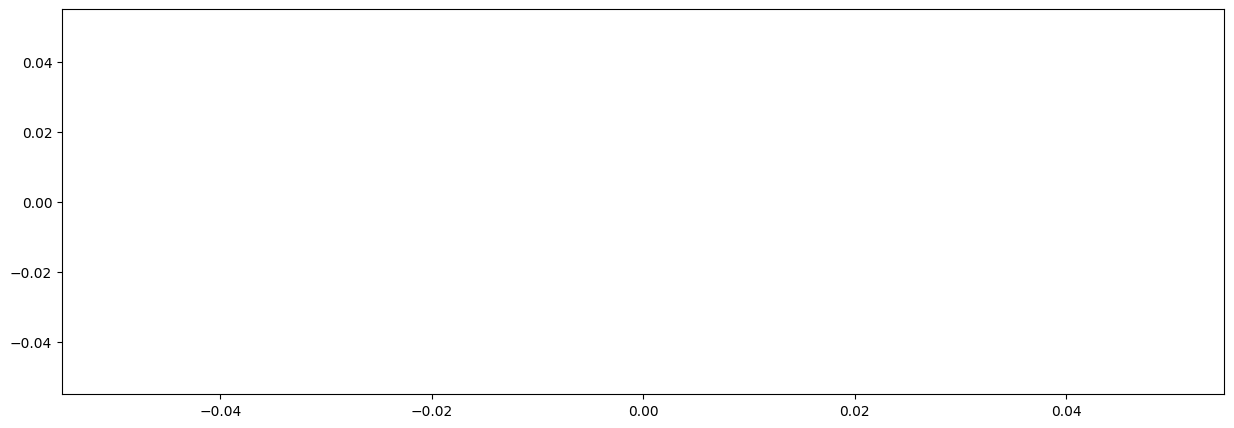

In [30]:
desc(m_events)

In [31]:
# проверка на отсутствие неявных дубликатов
m_events["name"].value_counts()

name
Christmas&New Year Promo            1
St. Valentine's Day Giveaway        1
St. Patric's Day Promo              1
Easter Promo                        1
4th of July Promo                   1
Black Friday Ads Campaign           1
Chinese New Year Promo              1
Labor day (May 1st) Ads Campaign    1
International Women's Day Promo     1
Victory Day CIS (May 9th) Event     1
CIS New Year Gift Lottery           1
Dragon Boat Festival Giveaway       1
Single's Day Gift Promo             1
Chinese Moon Festival               1
Name: count, dtype: int64

In [32]:
# проверка на отсутствие неявных дубликатов
m_events["regions"].value_counts()

regions
APAC                        4
EU, CIS, APAC, N.America    3
EU, N.America               2
EU, CIS, APAC               2
CIS                         2
N.America                   1
Name: count, dtype: int64

В результате изучения информации о датафрейме можно сделать следующие выводы:
- всего в 2020г. было проведено 14 маркетинговых событий;
- пропусков и дубликатов в датафрейме нет;
- названия столбцов соответсвуют `змеиному регистру`;
- необходимо поменять тип данных столбцов `start_dt` и `finish_dt` на datetime.

In [33]:
# поменяем тип данных столбцов `start_dt` и `finish_dt` на `datetime`
m_events["start_dt"] = m_events["start_dt"].map(
    lambda x: dt.datetime.strptime(x, "%Y-%m-%d")
)
m_events["finish_dt"] = m_events["finish_dt"].map(
    lambda x: dt.datetime.strptime(x, "%Y-%m-%d")
)

In [34]:
# проверка измененных типов данных
print(m_events.start_dt.dtype)
print(m_events.finish_dt.dtype)

datetime64[ns]
datetime64[ns]


**Датасет `new_users`**

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


Пропусков не осталось или произошла ошибка в первой части функции.


(None, None, None, 'Количество полных дубликатов в датафрейме: 0', None)

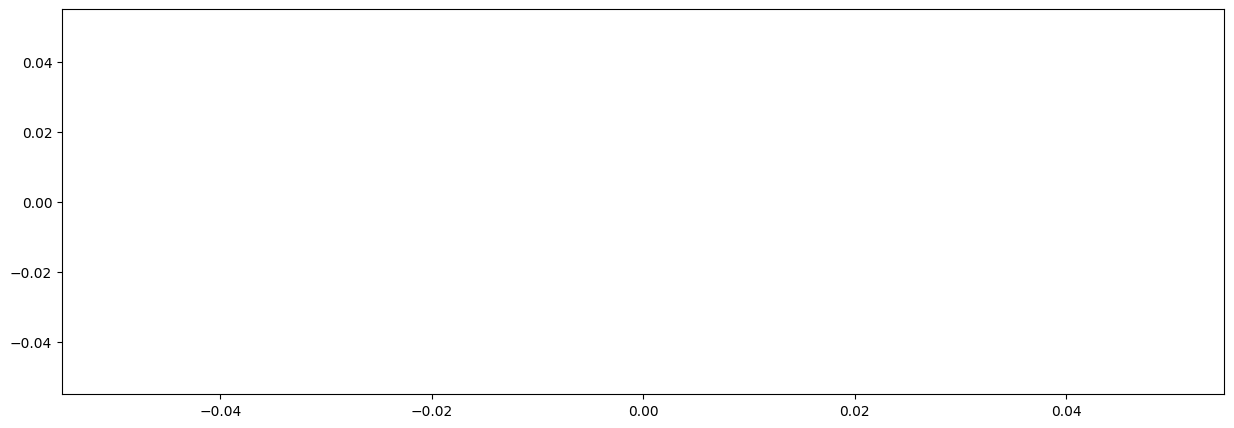

In [35]:
desc(new_users)

In [36]:
# проверка на отсутствие дублирующихся пользователей
new_users["user_id"].duplicated().sum()

0

In [37]:
# проверка на отсутствие неявных дубликатов
new_users["region"].value_counts()

region
EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: count, dtype: int64

In [38]:
# проверка на отсутствие неявных дубликатов
new_users["device"].value_counts()

device
Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: count, dtype: int64

В результате изучения информации о датафрейме можно сделать следующие выводы:
- каждая строка датафрейма содержит информацию об уникальном пользователе;
- пропусков и дубликатов в датафрейме нет;
- названия столбцов соответсвуют `змеиному регистру`;
- необходимо поменять тип данных столбца `first_date` на datetime.

In [39]:
# поменяем тип данных столбца `first_date` на `datetime`
new_users["first_date"] = new_users["first_date"].map(
    lambda x: dt.datetime.strptime(x, "%Y-%m-%d")
)

In [40]:
# проверка измененного типа данных
print(new_users.first_date.dtype)

datetime64[ns]


**Датасет `new_users_events`**

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


(None, None, None, 'Количество полных дубликатов в датафрейме: 0', None)

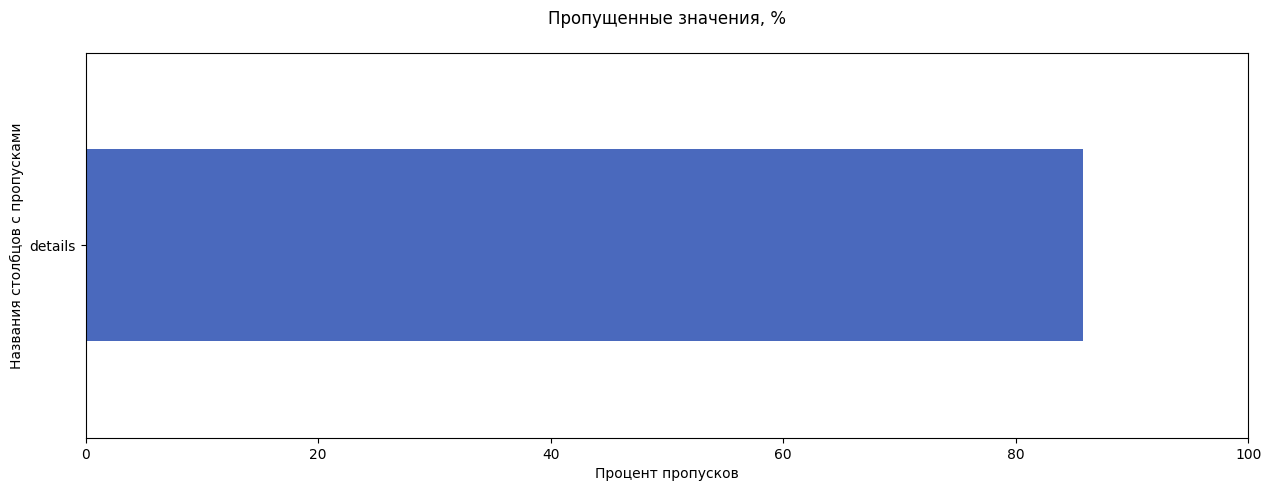

In [41]:
desc(new_users_events)

In [42]:
# проверка на отсутствие неявных дубликатов
new_users_events["event_name"].value_counts()

event_name
login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: count, dtype: int64

In [43]:
# проверка, связано ли наличие пропусков в `details` с типом события
new_users_events.groupby("event_name").agg({"event_name": "count", "details": "count"})

,event_name,details
event_name,,
login,189552,0
product_cart,62462,0
product_page,125563,0
purchase,62740,62740


В результате изучения информации о датафрейме можно сделать следующие выводы:
- дубликатов в датафрейме нет;
- столбце `details` есть пропуски, но это объяснимо: в нем содежится информация только для событий типа `purchase` -> не будем заменять пропуски заглушками, чтобы иметь возможность работы с числовым столбцом без предварительной фильтрации;
- названия столбцов соответсвуют `змеиному регистру`;
- необходимо поменять тип данных столбца `event_dt` на datetime.

In [44]:
# поменяем тип данных столбца `event_dt` на `datetime`
new_users_events["event_dt"] = new_users_events["event_dt"].map(
    lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
)

In [45]:
# проверка измененного типа данных
print(new_users_events.event_dt.dtype)

datetime64[ns]


**Датасет `ab_users`**

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


Пропусков не осталось или произошла ошибка в первой части функции.


(None, None, None, 'Количество полных дубликатов в датафрейме: 0', None)

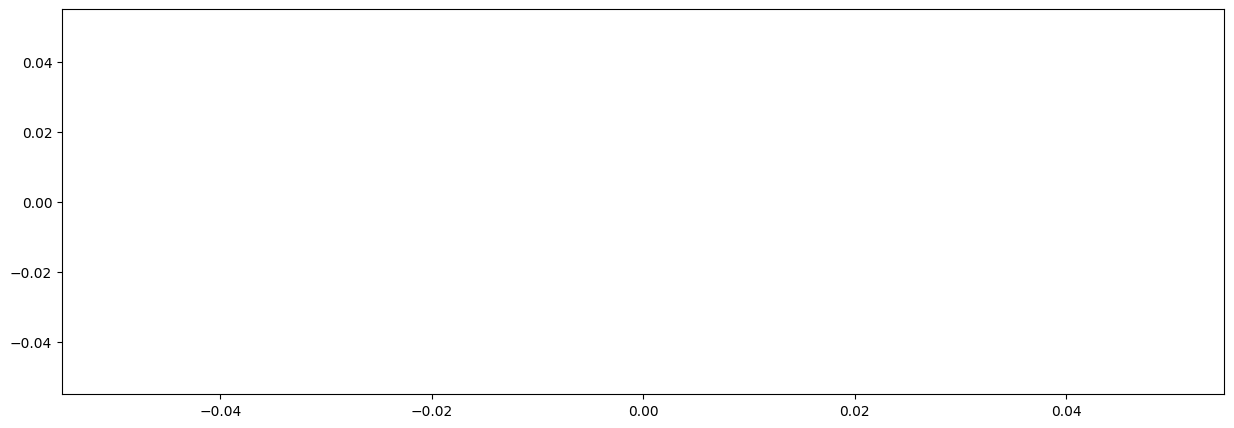

In [46]:
desc(ab_users)

In [47]:
# проверка на отсутствие неявных дубликатов
ab_users["group"].value_counts()

group
A    9655
B    8613
Name: count, dtype: int64

In [48]:
# проверка на отсутствие неявных дубликатов
ab_users["ab_test"].value_counts()

ab_test
interface_eu_test          11567
recommender_system_test     6701
Name: count, dtype: int64

In [49]:
# проверка на отсутствие дублирующихся пользователей
ab_users["user_id"].duplicated().sum()

1602

In [50]:
# проверка, есть ли дублирующиеся пользователи в рамках теста `recommender_system_test`
ab_users.query('ab_test == "recommender_system_test"')["user_id"].duplicated().sum()

0

In [51]:
# проверка, есть ли дублирующиеся пользователи в рамках теста `interface_eu_test`
ab_users.query('ab_test == "interface_eu_test"')["user_id"].duplicated().sum()

0

В результате изучения информации о датафрейме можно сделать следующие выводы:
- пропусков в датафрейме нет;
- названия столбцов соответсвуют `змеиному регистру`;
- типы данных корректные;
- в датафрейме есть 1602 пользователя, которые одновременно относятся к 2 разным тестам -> на этапе оценки корректности проведения теста определим, что сделаем с данными пользователям;
- в датафрейме нет ситуаций, когда пользователь одновременно относится к двум разным группам (А и B) в рамках одного теста.

**Вывод:**
В результате проведенной предобработки данных было сделано следующее:
- названия столбцов всех датафреймов проверены на соответствие `змеиному регистру`: все соответсввуют;
- типы данных следующих столбцов были изменены на `datetime`:
    - `start_dt` и `finish_dt` (датафрейм `m_events`);
    - `first_date` (датафрейм `new_users`);
    - `event_dt` (датафрейм `new_users_events`);
- все датафреймы проверены на отсутвие пропусков: пропуски были выявлены только в столбце `details` датафрейма `new_users_events`, но это объяснимо: в столбце содежится информация только для событий типа `purchase` -> не будем заменять пропуски заглушками, чтобы иметь возможность работы с числовым столбцом без предварительной фильтрации;
- все датафреймы проверены на отсутвие дубликатов: выявлено, что в датафрейме есть 1602 пользователя, которые одновременно относятся к 2 разным тестам (датафрейм `ab_users`), но, при этом, нет ситуаций, когда пользователь одновременно относится к двум разным группам (А и B) в рамках одного теста -> на этапе оценки корректности проведения теста определим, что сделаем с пользователями, которые относятся к 2 тестам одновременно.

## Оценка корректности проведения теста
[`Перейти к содержанию проекта`](#beginning)

1. Название теста - `recommender_system_test`: в датафрейме `ab_test` есть группа пользователей с данным названием теста (6701 пользователь). Назначение теста - тестирование изменений, связанных с внедрением улучшенной рекомендательной системы, название теста подходит под описание назначения.

Отфильтруем данные в датафреймах с информацией о распределении по группам (`ab_users`), о зарегистрированных пользователях (`new_users`) и их действиях (`new_users_events`) только о тех пользователях, которые относятся к тесту `recommender_system_test` и сохраним в новые датафреймы.

Также соединим информацию, указанную выше, о пользователях, которые относятся к тесту `recommender_system_test`, в один датафрейм. При объединении будем учитывать, что могут быть пользователи, которые были зарегистрированы (есть в `new_users`), но не совершали никаких действий (нет в `new_users_events`).

In [52]:
ab_users["ab_test"].value_counts()

ab_test
interface_eu_test          11567
recommender_system_test     6701
Name: count, dtype: int64

In [53]:
# информация о распределении по группам только тех пользователей,
# которые принимали участие в тесте `recommender_system_test`

ab_users_recom = ab_users.query('ab_test == "recommender_system_test"')

In [54]:
# список id пользователей, которые принимали участие в тесте `recommender_system_test`

ab_users_recom_list = ab_users_recom["user_id"].unique()
users_recom_count = len(ab_users_recom_list)
f"В тесте `recommender_system_test` принимало участие {users_recom_count} пользователей"

'В тесте `recommender_system_test` принимало участие 6701 пользователей'

In [55]:
# проверка, что группа распределяется в момент регистрации пользователя
len(new_users.query("user_id in @ab_users_recom_list")) == users_recom_count

True

In [56]:
# оставим также в датафремах с информацией о зарегистрированных пользователях и их действиях
# данные только о тех пользователях, которые относятся к тесту `recommender_system_test`

new_users_recom = new_users.query("user_id in @ab_users_recom_list")
new_users_events_recom = new_users_events.query("user_id in @ab_users_recom_list")

In [57]:
# соединим информацию о распределении по группам и регистрации пользователей,
# которые относятся к тесту `recommender_system_test`
all_data_recom = ab_users_recom.merge(new_users_recom)

# дополним предыдущий датафрей информацией о события пользователей
all_data_recom = all_data_recom.merge(new_users_events_recom, how="left")

In [58]:
new_users_no_events = len(all_data_recom) - len(new_users_events_recom)
f"Среди участников теста есть {new_users_no_events} пользователей, кто был зарегистрирован,\
но не совершал ни одного действия"

'Среди участников теста есть 3026 пользователей, кто был зарегистрирован,но не совершал ни одного действия'

Выявлено достаточно много участников теста, кто был зарегистрирован, но не совершил ни одно действие (а значит, не попал в исследуемую далее воронку действий). Запомним эту особенность при дальнейшей оценке необходимого количества пользователей, согласно тех. заданию.

2. Дата запуска - `2020-12-07`, дата остановки набора новых пользователей - `2020-12-21`: как видно на графике ниже, действительно, набор новых пользователей для теста `recommender_system_test` происходил в период с `2020-12-07` по `2020-12-21`.

In [59]:
new_users_dynamics = (
    all_data_recom.groupby("first_date")
    .agg({"user_id": "nunique"})
    .sort_values(by="first_date")
    .reset_index()
)
new_users_dynamics.columns = [
    "Дата регистрации",
    "Число зарегистрировавшихся пользователей",
]
new_users_dynamics

,Дата регистрации,Число зарегистрировавшихся пользователей
0,2020-12-07,645
1,2020-12-08,364
2,2020-12-09,258
3,2020-12-10,391
4,2020-12-11,277
5,2020-12-12,489
6,2020-12-13,581
7,2020-12-14,665
8,2020-12-15,359
9,2020-12-16,285


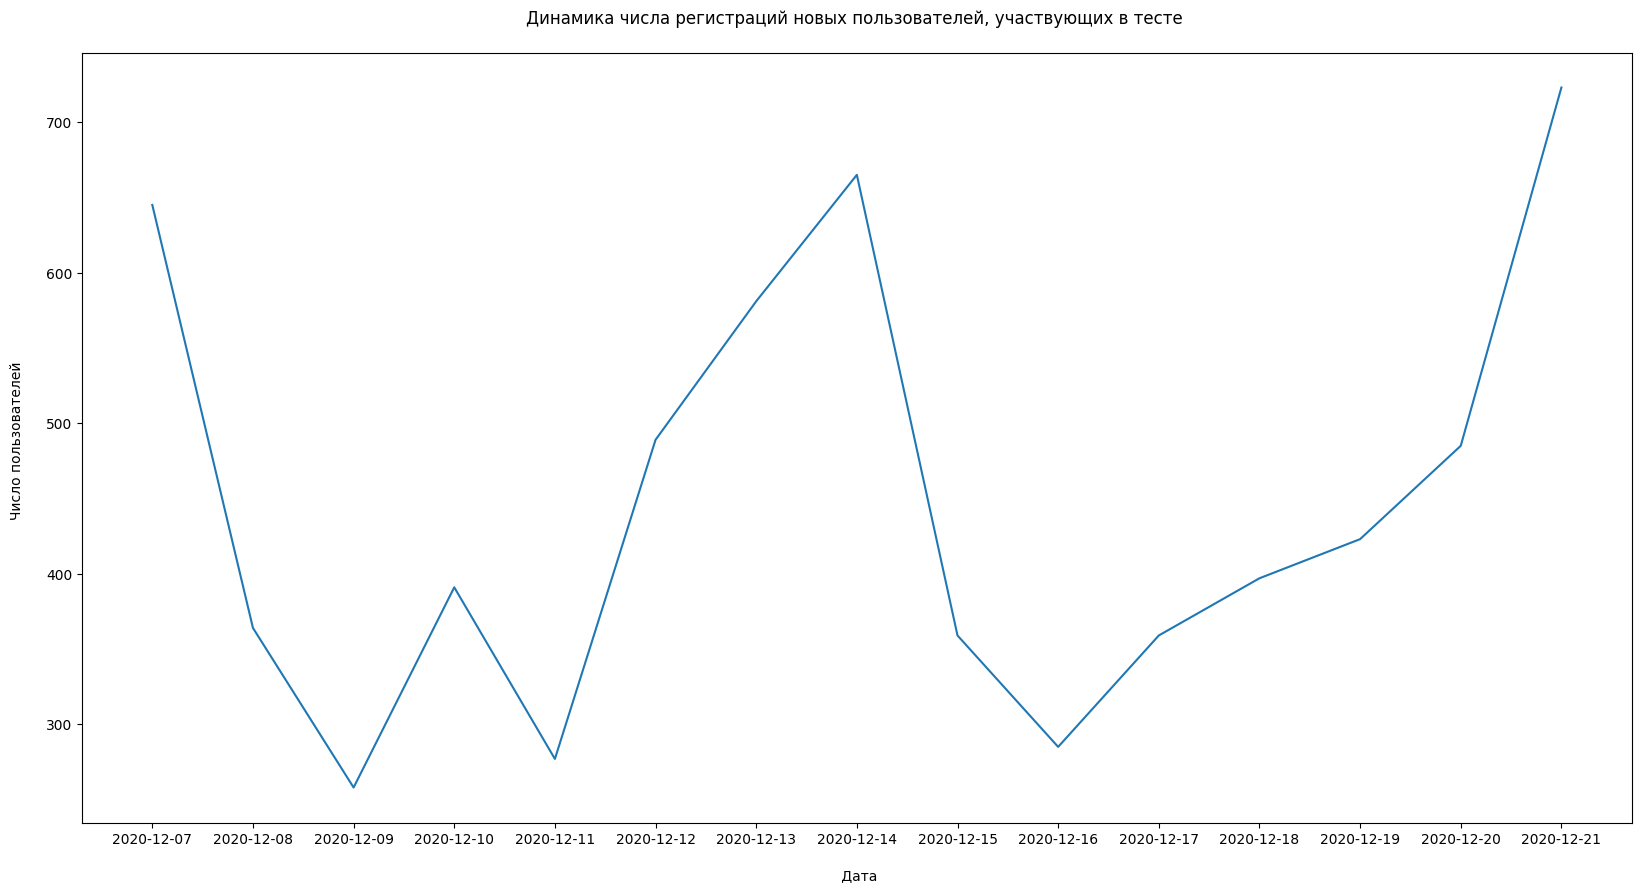

In [60]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

plt.plot(
    new_users_dynamics["Дата регистрации"],
    new_users_dynamics["Число зарегистрировавшихся пользователей"],
)
plt.xticks(new_users_dynamics["Дата регистрации"])
ax.set_title("Динамика числа регистраций новых пользователей, участвующих в тесте \n")
ax.set_xlabel("\n Дата")
ax.set_ylabel("Число пользователей \n")
plt.rc("axes", titlesize=15)
plt.xticks(rotation=0)

plt.show()

Набор новых пользователей для теста `recommender_system_test` происходил в период с `2020-12-07` по `2020-12-21`. 

Посмотрим дополнительно, за какой период представлены данные о регистрации новых пользователи во всем датафреме, а не только по изучаемому тесту:

In [61]:
all_new_users_dynamics = (
    new_users.groupby("first_date")
    .agg({"user_id": "nunique"})
    .sort_values(by="first_date")
    .reset_index()
)
all_new_users_dynamics.columns = [
    "Дата регистрации",
    "Число зарегистрировавшихся пользователей",
]
all_new_users_dynamics

,Дата регистрации,Число зарегистрировавшихся пользователей
0,2020-12-07,5595
1,2020-12-08,3239
2,2020-12-09,2101
3,2020-12-10,3076
4,2020-12-11,2390
5,2020-12-12,3963
6,2020-12-13,4691
7,2020-12-14,5654
8,2020-12-15,3043
9,2020-12-16,2110


Во всем датафрейме представлены данные о регистрации пользователей дополнительно еще за 2 дня по сравнению в данными о регистрации новых пользователей, которые относятся к тесту `recommender_system_test`. Предположительно, это не должно повлиять на наше исследование, так как мы будем анализировать данные только по тесту `recommender_system_test`, но будем иметь эту особенность в виду.

3. Дата запуска - `2020-12-07`, дата остановки - `2021-01-04`: как видно на графике ниже, последняя дата событий пользователей -  `2020-12-30`. При этом, в этот день резко упало количество событий (всего 4 события). Есть вероятность, что пользователи действительно не совершали действий после `2020-12-30`, но, скорее всего, данные неполные.

In [62]:
all_data_recom["event_date"] = all_data_recom["event_dt"].dt.date

In [63]:
new_users_events_dynamics = (
    all_data_recom.groupby("event_date")
    .agg({"user_id": "nunique"})
    .sort_values(by="event_date")
    .reset_index()
)
new_users_events_dynamics.columns = ["Дата события", "Число событий"]
new_users_events_dynamics

,Дата события,Число событий
0,2020-12-07,327
1,2020-12-08,280
2,2020-12-09,350
3,2020-12-10,296
4,2020-12-11,274
5,2020-12-12,280
6,2020-12-13,251
7,2020-12-14,619
8,2020-12-15,589
9,2020-12-16,643


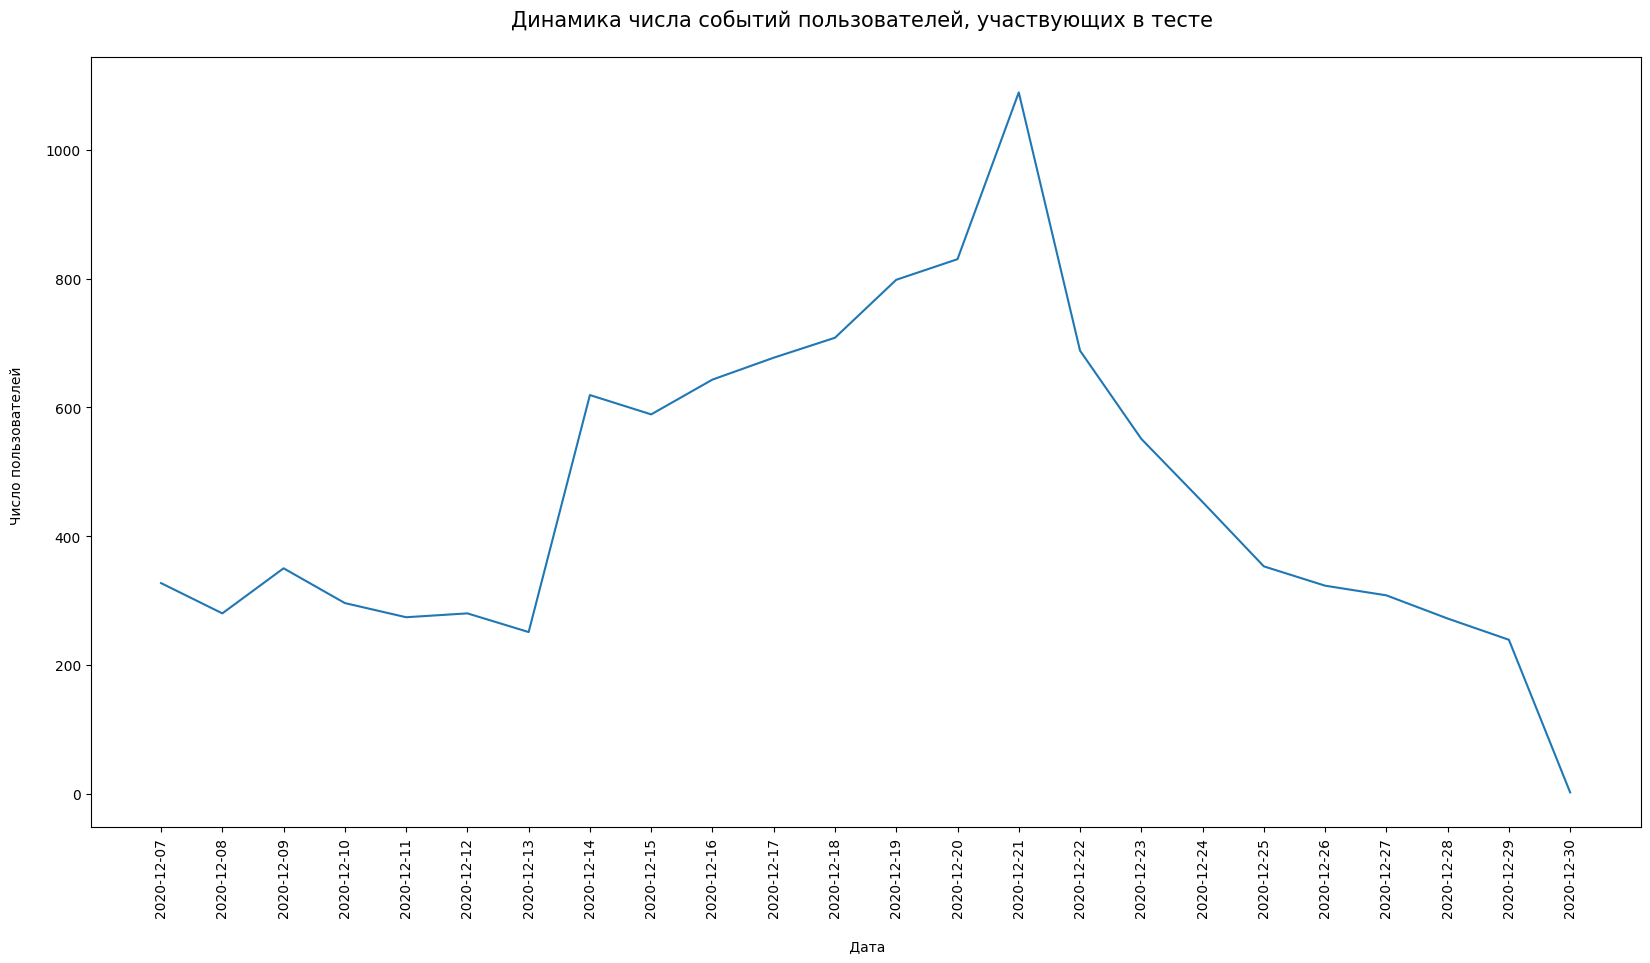

In [64]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

plt.plot(
    new_users_events_dynamics["Дата события"],
    new_users_events_dynamics["Число событий"],
)
plt.xticks(new_users_events_dynamics["Дата события"])
ax.set_title("Динамика числа событий пользователей, участвующих в тесте \n")
ax.set_xlabel("\n Дата")
ax.set_ylabel("Число пользователей \n")
plt.rc("axes", titlesize=15)
plt.xticks(rotation=90)

plt.show()

Как видно на графике ниже, последняя дата событий пользователей - `2020-12-30`. При этом, в этот день резко упало количество событий. Есть вероятность, что пользователи действительно не совершали действий после `2020-12-30`, но, скорее всего, данные неполные. Аналогичная ситуация не только по событиям пользователей, связанных с изучаемым тестом `recommender_system_test`.

In [65]:
new_users_events["event_date"] = new_users_events["event_dt"].dt.date
all_new_users_events = (
    new_users_events.groupby("event_date")
    .agg({"user_id": "count"})
    .sort_values(by="event_date")
    .reset_index()
)
all_new_users_events.columns = ["Дата события", "Число событий"]
all_new_users_events.tail()

,Дата события,Число событий
19,2020-12-26,14058
20,2020-12-27,12420
21,2020-12-28,11014
22,2020-12-29,10146
23,2020-12-30,89


4. Группы:
    - А — контрольная,
    - B — новая платёжная воронка;
    
Действительно, пользователи, вовлеченные в тест `recommender_system_test` разделены в датафрейме на 2 группы: A и B. 

In [66]:
all_data_recom.groupby("group").agg({"user_id": "nunique"})

,user_id
group,
A,3824
B,2877


На этапе предобработки данных мы выявили, что есть 1602 пользователя, которые одновременно относятся к 2 разным тестам. Это является нарушением проведения теста. Проверим, сколько участников исследуемого теста попали в группу A и группу B другого теста.

In [67]:
duplicated_users = ab_users[ab_users["user_id"].duplicated()]["user_id"].unique()
duplicated_users_info = ab_users.query("user_id in @duplicated_users")

new_users.query("user_id in @duplicated_users")[
    "region"
].value_counts()  # из какого региона дублирующиеся пользователи

region
EU    1602
Name: count, dtype: int64

In [68]:
duplicated_interface_eu_a = duplicated_users_info.query(
    'ab_test == "interface_eu_test" and group == "A"'
)
duplicated_interface_eu_a = duplicated_interface_eu_a["user_id"].unique()
f"Среди участников исследуемого теста есть {len(duplicated_interface_eu_a)} пользователей, \
которые также были в группе A другого теста."

'Среди участников исследуемого теста есть 819 пользователей, которые также были в группе A другого теста.'

In [69]:
duplicated_interface_eu_b = duplicated_users_info.query(
    'ab_test == "interface_eu_test" and group == "B"'
)
duplicated_interface_eu_b = duplicated_interface_eu_b["user_id"].unique()
f"Среди участников исследуемого теста есть {len(duplicated_interface_eu_b)} пользователей, \
которые также были в группе B другого теста."

'Среди участников исследуемого теста есть 783 пользователей, которые также были в группе B другого теста.'

In [70]:
# распределение пользователей по регионам для теста `recommender_system_test`
all_data_recom.groupby("region").agg({"user_id": "nunique"}).sort_values(
    by="user_id", ascending=False
)

,user_id
region,
EU,6351
N.America,223
APAC,72
CIS,55


In [71]:
# распределение пользователей по регионам для теста `interface_eu_test`
new_users.query("~(user_id in @ab_users_recom_list)")["region"].value_counts()

region
EU           39919
N.America     8932
CIS           3100
APAC          3081
Name: count, dtype: int64

Все дублирующиеся пользователи - из региона EU, тесты - конкурирующие, направлены преимущественно на аудиторию EU.

Для корректного проведения теста из участников исследуемого теста `recommender_system_test` необходимо исключить пользователей, которые находились в группе B другого теста (`interface_eu_test`): 783 пользователя, так как изменения, внесенные в рамках теста `interface_eu_test` могли повлиять на поведение пользователей исследуемого теста `recommender_system_test`.

При этом, 819 пользователей, которые относились к группе A другого теста, можно оставить, так как изменения в рамках другого теста не вносились и не должны повлиять на поведение пользователей в рамках исследуемого теста. Но, в любом случае, наличие таких пересечений является нарушением проведения A/B теста, а систему распределения пользователей необходимо исправить для корректного распределения пользователей между тестами (без каких-либо пересечений).

In [72]:
# удалим из датафрейма исследуемого теста пользователей, которые попали в группу B другого теста

all_data_recom = all_data_recom.query("~(user_id in @duplicated_interface_eu_b)")

Также ранее мы уже проверили, что нет нарушений в рамках принадлежности пользователей разным группам одного и того же теста одновременно. Следовательно, это условие для корректного проведения A/B теста выполняется

In [73]:
# проверим, сколько участников теста осталось после удаления некоторых пересекающихся с другим тестов пользователей

all_data_recom["user_id"].agg("nunique")

5918

In [74]:
# посчитаем, сколько осталось зарегистрированных пользователей без действий

all_data_recom.query("event_dt.isna()")["user_id"].agg("nunique")

2674

После удаления некоторых пересекающихся с другим тестов пользователей участников теста стало менее ожидаемого (мене 6000).

5. Время проведения теста совпадает с маркетинговыми и другими активностями: на поведение пользователей теста могли повлиять маркетинговые активности (в большей степени 1 активность: `Christmas&New Year Promo`), однако, эти активности одинаково повлияют на две группы (и на A, и на B). Наличие пересекающихся активностей и времени проведения теста нужно учитывать при изучении абсолютных данных, но на относительную конверсию группы В к группе А - не будут иметь воздействие. Поэтому не будем удалять данные за какой-либо период, чтобы исключить влияние событий и праздников. 

Также, в целом, стоит учитывать, что время проведения теста - пора перед Рождественскими и новогодними праздниками, когда поведение клиентов сильно меняется и, как правило, повышается потребительский спрос. Выявленное увеличение активности участников теста в период `2020-12-14` по `2020-12-21` как раз может быть связано с наступающим католическим Рождеством.

Посмотрим, из каких регионов пользователи исследуемого теста.

In [75]:
all_data_recom.groupby("region").agg({"user_id": "nunique"}).sort_values(
    by="user_id", ascending=False
)

,user_id
region,
EU,5568
N.America,223
APAC,72
CIS,55


Пользователи исследуемого теста перимущественно из EU и N.America. 

В целом, можно отметить, что время проведения теста - пора перед Рождественскими и новогодними праздниками, когда поведение клиентов сильно меняется и, как правило, повышается потребительский спрос

Посмотрим на динамику числа событий пользователей (не только участвующих в тесте).

In [76]:
new_users_events_dynamics = (
    all_data_recom.groupby("event_date")
    .agg({"user_id": "nunique"})
    .sort_values(by="event_date")
    .reset_index()
)
new_users_events_dynamics.columns = ["Дата события", "Число событий"]

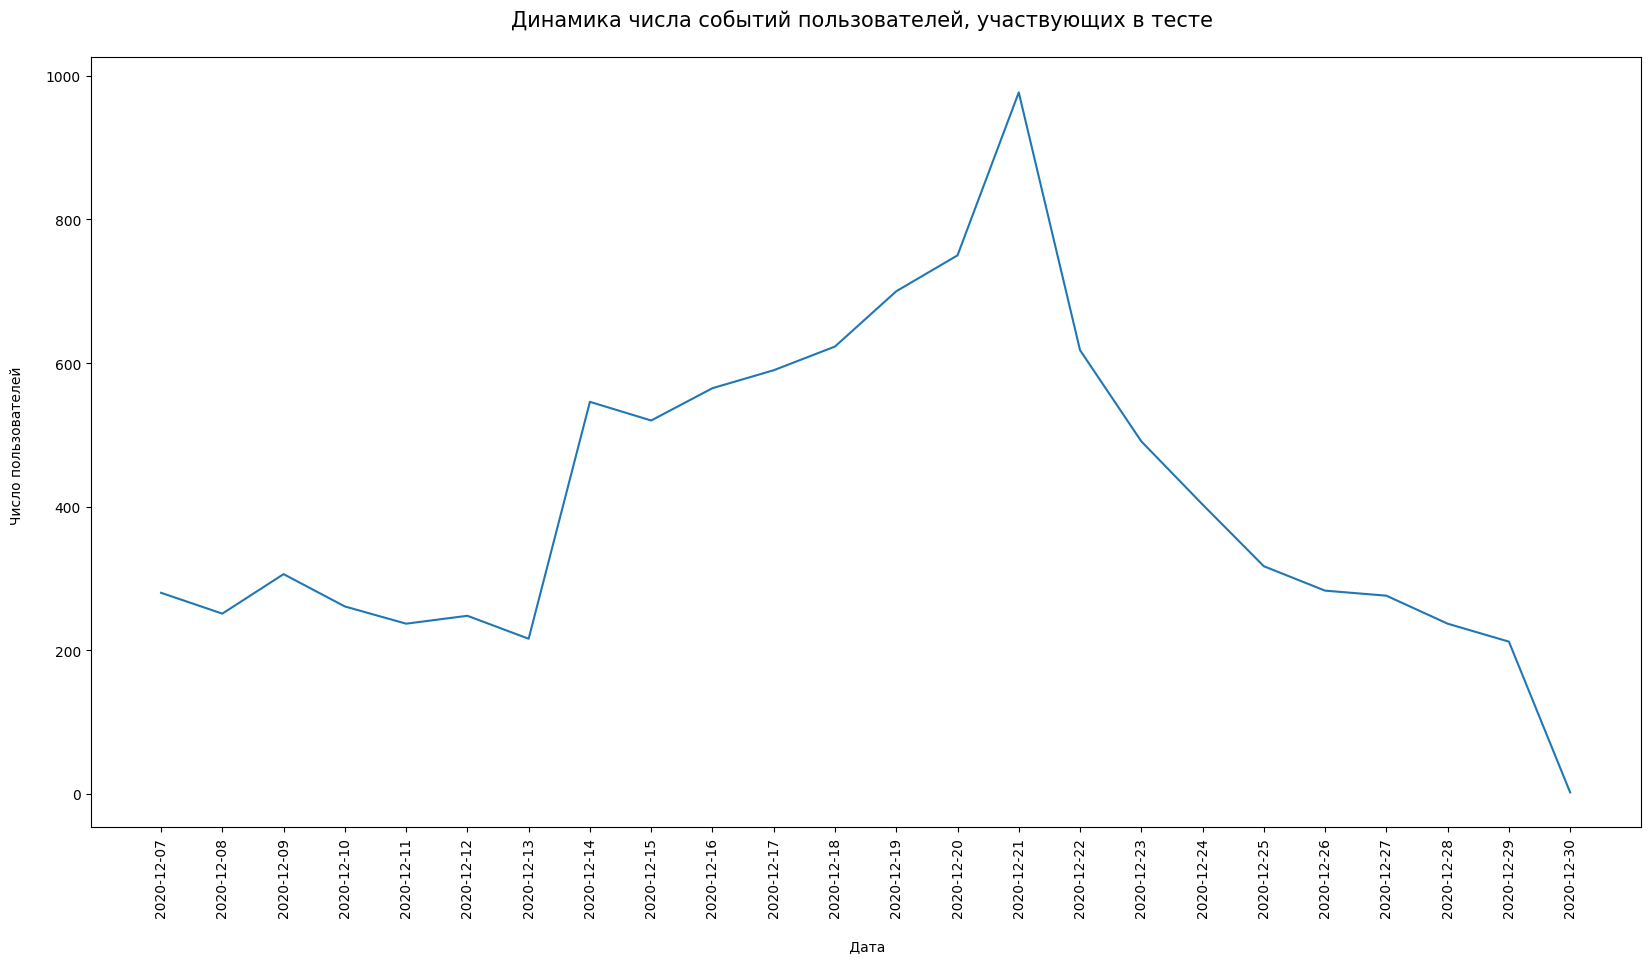

In [77]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

plt.plot(
    new_users_events_dynamics["Дата события"],
    new_users_events_dynamics["Число событий"],
)
plt.xticks(new_users_events_dynamics["Дата события"])
ax.set_title("Динамика числа событий пользователей, участвующих в тесте \n")
ax.set_xlabel("\n Дата")
ax.set_ylabel("Число пользователей \n")
plt.rc("axes", titlesize=15)
plt.xticks(rotation=90)

plt.show()

Наблюдается увеличение активности участников теста в период с 14 по 21 декабря. Как раз мог сказаться факт наступающего католического Рождества.

In [78]:
new_users_dynamics = (
    all_data_recom.groupby("first_date")
    .agg({"user_id": "nunique"})
    .sort_values(by="first_date")
    .reset_index()
)
new_users_dynamics.columns = [
    "Дата регистрации",
    "Число зарегистрировавшихся пользователей",
]

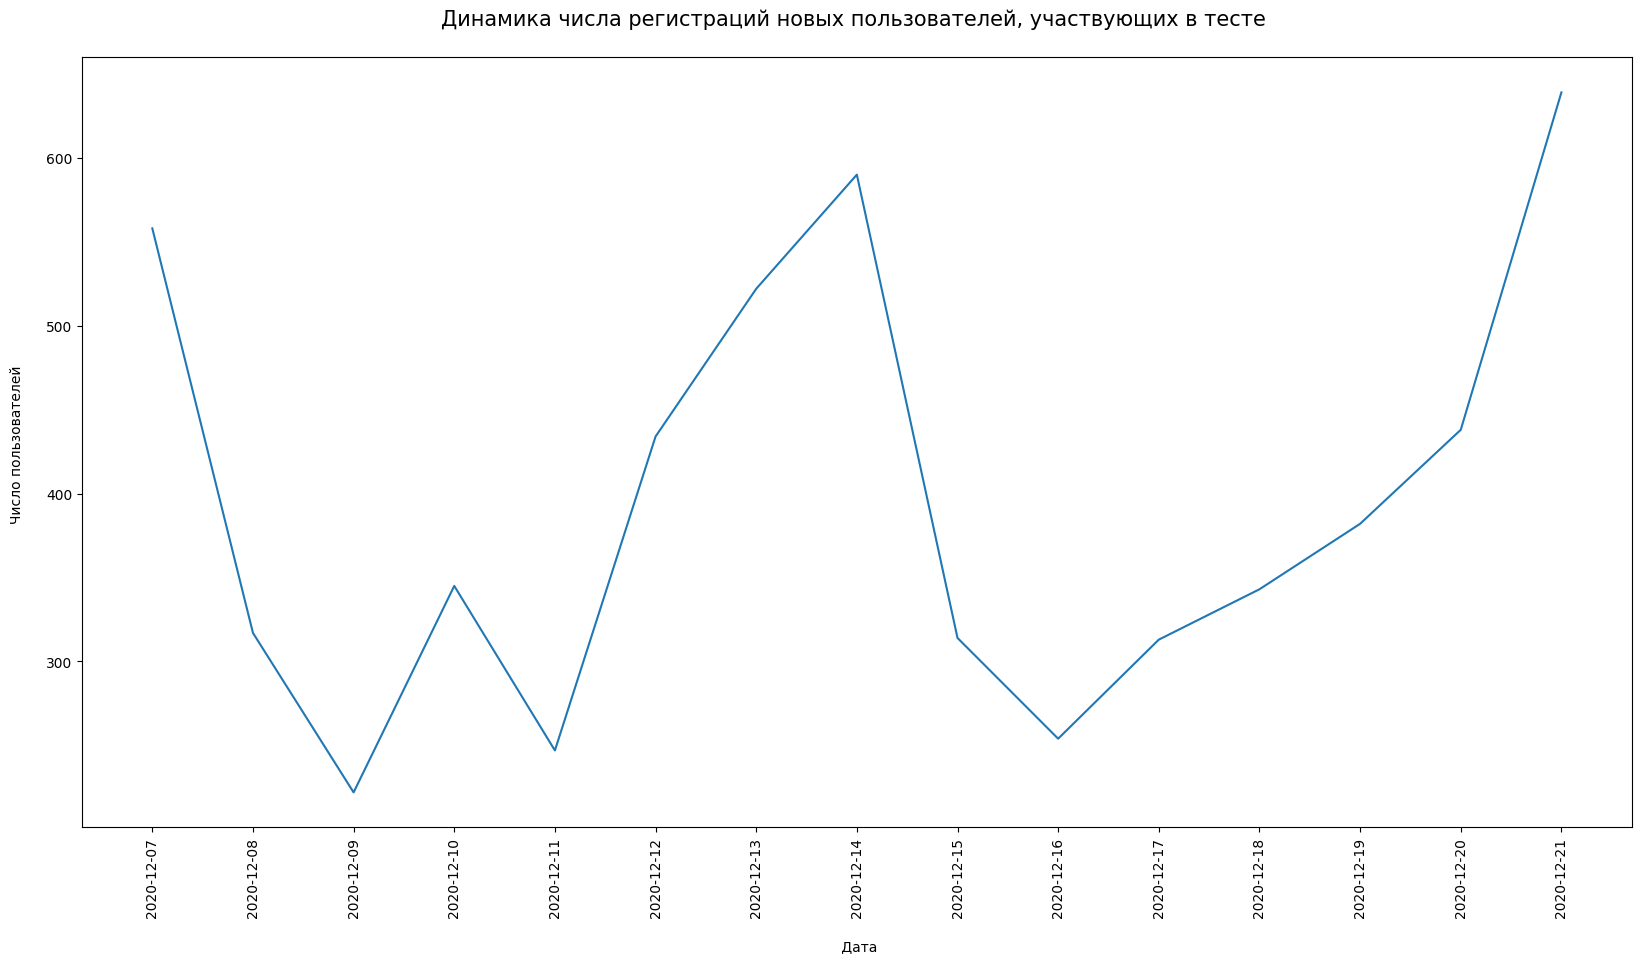

In [79]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

plt.plot(
    new_users_dynamics["Дата регистрации"],
    new_users_dynamics["Число зарегистрировавшихся пользователей"],
)
plt.xticks(new_users_dynamics["Дата регистрации"])
ax.set_title("Динамика числа регистраций новых пользователей, участвующих в тесте \n")
ax.set_xlabel("\n Дата")
ax.set_ylabel("Число пользователей \n")
plt.rc("axes", titlesize=15)
plt.xticks(rotation=90)

plt.show()

Новые пользователи за исследуемый период тоже регистрируются неравномерно: также наблюдаются, в том числе, пики 7, 14 и 21 декабря.

  Проверим, пересекались ли действия пользователей с периодами проведения маркетинговых активностей.    
Выведем даты первого и последнего события пользователей исследуемого теста:

In [80]:
min_event_date = min(all_data_recom["event_dt"])
max_event_date = max(all_data_recom["event_dt"])

print(f"Минимальная дата события участника теста: {min_event_date}")
print(f"Максимальная дата события участника теста: {max_event_date}")

Минимальная дата события участника теста: 2020-12-07 00:05:57
Максимальная дата события участника теста: 2020-12-30 12:42:57


In [81]:
m_events.query("start_dt >= @min_event_date and start_dt <= @max_event_date")

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


2 маркетинговых активности пересекаются с периодом активности участников теста. При этом, активность `CIS New Year Gift Lottery` затрагивает только 1 день `2020-12-30`, когда, как мы выяснили ранее, данных об активности клиентов уже совсем мало.
Активность `Christmas&New Year Promo` затрагивает исследуемый период активности пользователей с `2020-12-25` по `2020-12-30`. Более того, эта активность проводилась для пользователей регионов, из которых преимущественно участники теста: EU и N.America.

Однако, указанные выше активности одинаково повлияют на две группы (и на A, и на B). Наличие пересекающихся активностей и времени проведения теста нужно учитывать при изучении абсолютных данных, но на относительную конверсию группы В к группе А - не будут иметь воздействие.    
Поэтому не будем удалять данные за какой-либо период, чтобы исключить влияние событий и праздников, но будем учитывать их наличие при анализе абсолютных значений. 

6. Ожидаемый эффект - за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%.

Сам эффект мы проверим позже, а сейчас проверим:
- все события в данных совершены не позже, чем в течение 14 дней после регистрации пользователя;
- есть ли пользователи, которые были зарегистрированы, но не совершили ни одного действия;
- есть ли пользователи, для которых представлена информация о событиях менее, чем за 14 дней, после регистрации (из-за удаления данных для исключения влияния маркетинговой активности и из-за изначально неполных данных (до `2020-12-30`)).

Вычислим для каждого события в рамках теста число дней между датой регистрации пользователя и этим событием. Далее удалим все действия, которые были совершены позже, чем через 14 дней после регистрации, так как, согласно техническому заданию, нас интересует эффект, который покажут пользователи за 14 дней с момента регистрации.

In [82]:
all_data_recom["days_diff"] = all_data_recom["event_dt"] - all_data_recom["first_date"]
all_data_recom = all_data_recom.query('days_diff <= "14 days" or event_dt.isna()')

In [83]:
# проверим, сколько участников теста осталось после удаления
all_data_recom["user_id"].agg("nunique")

5918

В начале исследования мы отметили, что есть пользователи, которые не совершили ни одного действия после регистрации. Проверим, сколько их сейчас.

In [84]:
# проверим, остались ли пользователи без действий
all_data_recom.query("event_dt.isna()")["user_id"].agg("nunique")

2674

2674 пользователей из 5918 участников теста не совершали ни одного действия после регистрации. Это могут быть пользователи, которые только зарегистрировались и больше не заходили на ресурс, или это может быть ошибка в логировании:
- если первое - то таких пользователей нужно учитывать;
- если второе - то лучше отфильтровать.
Для проверки посмотрим на распределение этих пользователей в группе А и В, а также динамику их набора по дням: при отсутствии ошибок мы должны иметь плюс-минус схожее поведение для групп А и В.

In [85]:
# распределение по группамм всех участников теста
all_data_recom.groupby("group").agg({"user_id": "nunique"})

,user_id
group,
A,3385
B,2533


In [86]:
# распределение по группамм участников теста, которые не совершили ни одно действие после регистрации
all_data_recom.query("event_dt.isna()").groupby("group").agg({"user_id": "nunique"})

,user_id
group,
A,963
B,1711


Распределение по группамм участников теста, которые не совершили ни одно действие после регистрации, отличается от распределения по группамм всех участников теста: к группе B относится почти в 2 раза больше неактивных участников.

In [87]:
# динамика по группам

new_users_dynamics = (
    all_data_recom.query("event_dt.isna()")
    .pivot_table(
        index="first_date", columns="group", values="user_id", aggfunc="nunique"
    )
    .sort_values(by="first_date")
    .reset_index()
)
new_users_dynamics.columns = [
    "Дата регистрации",
    "Число новых пользователей группы A",
    "Число новых пользователей группы B",
]

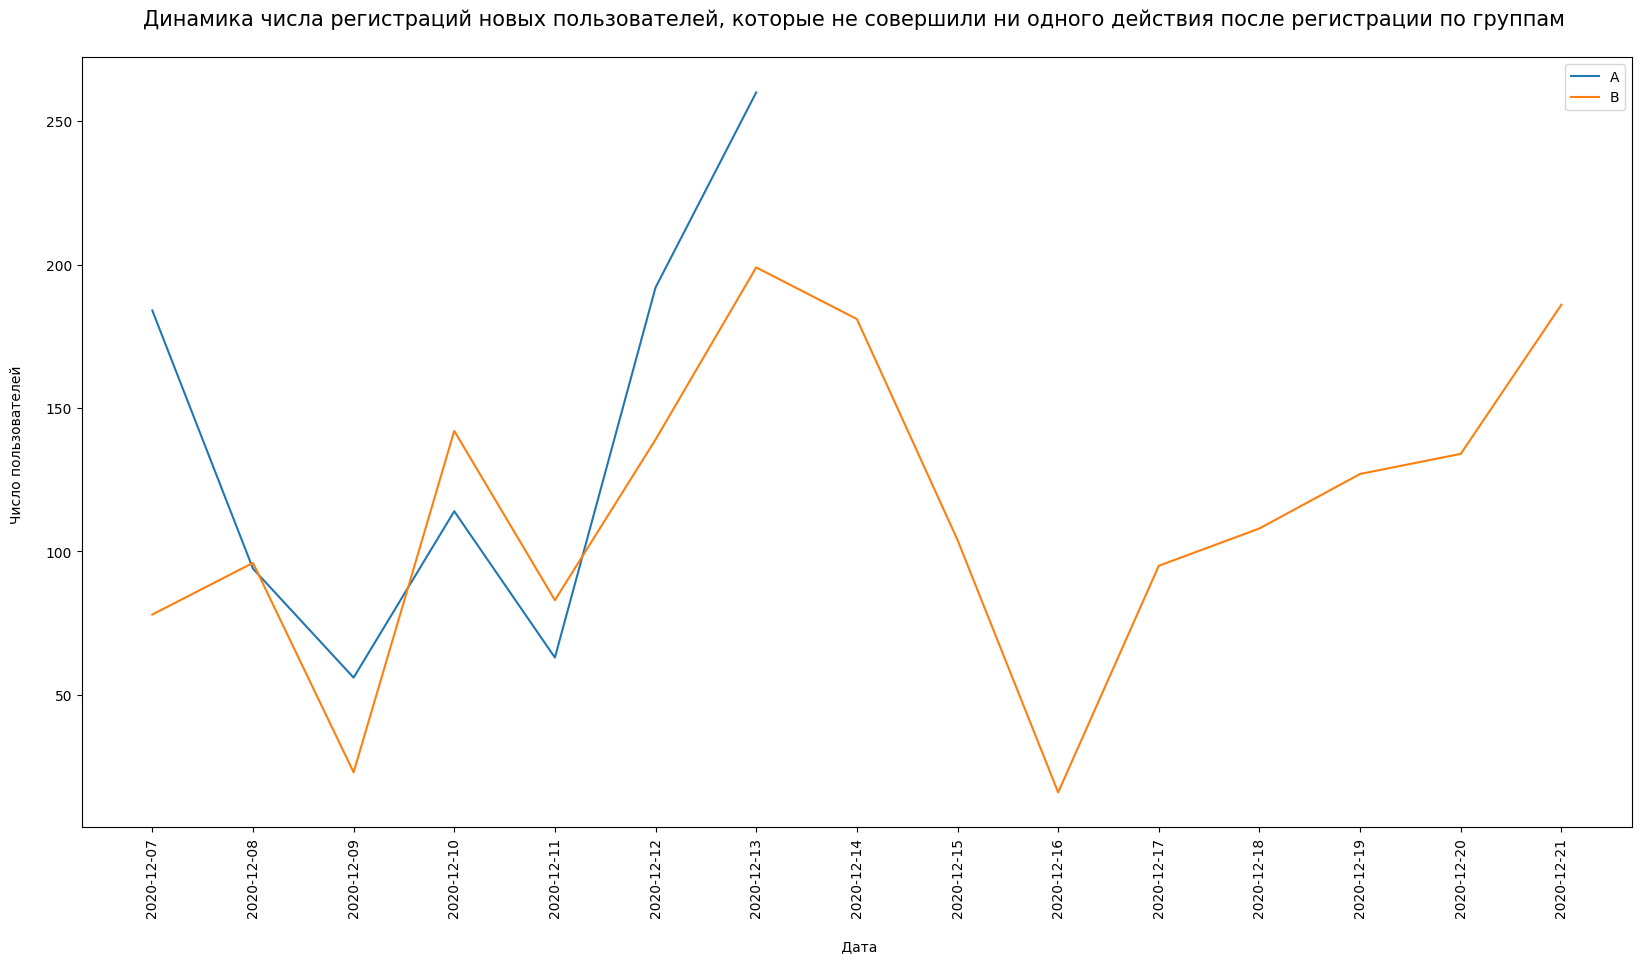

In [88]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

plt.plot(
    new_users_dynamics["Дата регистрации"],
    new_users_dynamics["Число новых пользователей группы A"],
    new_users_dynamics["Дата регистрации"],
    new_users_dynamics["Число новых пользователей группы B"],
)
plt.xticks(new_users_dynamics["Дата регистрации"])
ax.set_title(
    "Динамика числа регистраций новых пользователей, которые не совершили ни одного действия после регистрации по группам \n"
)
ax.set_xlabel("\n Дата")
ax.set_ylabel("Число пользователей \n")
plt.rc("axes", titlesize=15)
plt.xticks(rotation=90)
plt.legend(["A", "B"])

plt.show()

Как видно на графике, распределение неактивных далее пользователей между группами до `2020-12-13` происходит более-менее равномерно, но, начиная с `2020-12-14` все такие пользователи относятся только к группе B. Скорее всего, произошла какая-то техническая ошибка, поэтому для корректности результатов исследования удалим из датафрейма данные о неактивных пользователях, зарегистрированных с `2020-12-14`.

In [89]:
# число неактивных пользователей, которых удалим
len(all_data_recom.query('event_dt.isna() and first_date >= "2020-12-14"'))

951

In [90]:
all_data_recom = all_data_recom.query(
    '~(event_dt.isna() and first_date >= "2020-12-14")'
)

In [91]:
# проверим, сколько участников теста осталось после удаления
all_data_recom["user_id"].agg("nunique")

4967

Также стоит отметить, что из-за изначально неполных данных (событиях пользователей только до `2020-12-30`, а не до `2020-01-04`, на описано в тех.задании), в данных есть пользователи, для которых представлена информация о событиях за период менее, чем 14 дней после регистрации.

Сейчас можно считать, что полные данные о событиях представлены до `2020-12-29` включительно, поэтому для пользователей, зарегистрированных в период с `2020-12-17` по `2020-12-21` включительно, у нас есть неполная информация об их действиях (не за все 14 дней).    
Посчитаем, сколько таких пользователей.

In [92]:
all_data_recom.query('first_date >= "2020-12-17"')["user_id"].agg("nunique")

1465

Пользователей с неполной информацией о событиях (менее, чем за 14 дней после их регистрации) 1465 клиентов. Если их удалить из датафрейма, то останется совсем мало участников теста для дальнейшего анализа. Оставим их, но отметим, что неполная информация может повлиять на результаты исследования. Если бы данные о событиях пользователей изначально были полные, то результаты исследования могли быть более точными.

7. Ожидаемое количество участников теста - 6000:

In [93]:
users_count = all_data_recom["user_id"].agg("nunique")
f"Число пользователей, принимавших участие в тесте: {users_count}"

'Число пользователей, принимавших участие в тесте: 4967'

Таким образом, в результате осталось 4967 участников теста, что менее ожидаемого.

8. Аудитория - в тест должно быть отобрано 15% новых пользователей из региона EU: только 11% новых пользователей из EU отобрано в тест.

In [94]:
# посчитаем, сколько всего новых пользователей зарегистрировалось в период набора новых пользователей для теста
# с `2020-12-07` по `2020-12-21`

new_users_eu_all = new_users.query(
    'region == "EU" and first_date >= "2020-12-07" and first_date <= "2020-12-21"'
)["user_id"].agg("nunique")
users_eu_test = all_data_recom.query('region == "EU"')["user_id"].agg("nunique")
eu_users_percent = round(
    users_eu_test / new_users_eu_all * 100,
)
f"В результате, {eu_users_percent} % пользователей из EU, зарегистрированных в период набора новых пользователей для теста, были отобраны в тест."

'В результате, 11 % пользователей из EU, зарегистрированных в период набора новых пользователей для теста, были отобраны в тест.'

Таким образом, после удаления пользователей и событий, чтобы не нарушать правила проведения A/B теста, осталось только 11% пользователей из EU, которые были включены в тест.

9. Распределение по группам: в дополнение проверим, что итоговые группы распределены равномерно и правильно.

In [95]:
all_data_recom.groupby("group").agg({"user_id": "nunique"})

,user_id
group,
A,3385
B,1582


После проделанных выше действий также наблюдается неравное распределение по группам: в контрольной группе в 2 раза больше пользователей, чем в группе B.    
В целом, необязательно, чтобы выборки были сбалансированы по количеству наблюдений, но мощность критерия будет максимальной тогда, когда количество наблюдений в каждой из веток эксперимента наиболее близко друг к
другу.    
В нашем случае тест завершился раньше, а также число наблюдений менее ожидаемого на 18%. Поэтому неравное распределение по группам может сказать на результатах теста. Проверим, насколько равномерно распределялись пользователи по группам во время исследовательского анализа данных.

In [96]:
groups_by_regions = all_data_recom.pivot_table(
    index="region", columns="group", values="user_id", aggfunc="nunique"
).reset_index()
groups_by_regions["share_A"] = (
    groups_by_regions["A"] / groups_by_regions["A"].sum()
).round(2)
groups_by_regions["share_B"] = (
    groups_by_regions["B"] / groups_by_regions["B"].sum()
).round(2)
groups_by_regions

group,region,A,B,share_A,share_B
0,APAC,37,26,0.01,0.02
1,CIS,25,18,0.01,0.01
2,EU,3195,1475,0.94,0.93
3,N.America,128,63,0.04,0.04


Распределение между группами A и B по региону отличается незначительно.

In [97]:
groups_by_device = all_data_recom.pivot_table(
    index="device", columns="group", values="user_id", aggfunc="nunique"
).reset_index()
groups_by_device["share_A"] = (
    groups_by_device["A"] / groups_by_device["A"].sum()
).round(2)
groups_by_device["share_B"] = (
    groups_by_device["B"] / groups_by_device["B"].sum()
).round(2)
groups_by_device

group,device,A,B,share_A,share_B
0,Android,1488,737,0.44,0.47
1,Mac,314,142,0.09,0.09
2,PC,883,378,0.26,0.24
3,iPhone,700,325,0.21,0.21


Распределение между группами A и B по устройству отличается незначительно.

Проверим, не входят ли одни и те же участники теста в 2 группы (A и B) одновременно: 

In [98]:
group_a_users = all_data_recom.query('group == "A"')["user_id"].unique()
crossed_users = len(all_data_recom.query('group == "B" and user_id in @group_a_users'))
f"{crossed_users} участников теста одновременно относятся к обеим группам (A и B)"

'0 участников теста одновременно относятся к обеим группам (A и B)'

**Вывод о корректности проведения теста:**
В результате проведенного исследования были выявлены нарушения, которые могут значительно повлиять на результаты теста:
- Данные о событиях пользователей предоставлены неполные: только за период по `2020-12-30` (в этот день тоже, скорее всего, данные неполные) вместо указанного в техническом задании периода по `2020-01-04`;
- Было выявлено некорректное распределение пользователей между конкурирующими тестами (1602 пользователя, которые одновременно относятся к 2 разным тестам). При этом, для корректного проведения теста пришлось исключить пользователей, которые находились в группе B конкурирующего теста (783 пользователя), так как изменения, внесенные в рамках другого теста, могли повлиять на поведение пользователей исследуемого теста.
    - 819 пользователей, относящиеся к группе A другого теста, были оставлены, так как изменения в рамках другого теста не вносились и не должны повлиять на поведение пользователей в рамках исследуемого теста. Но, в любом случае, наличие таких пересечений является нарушением проведения A/B теста, а систему распределения пользователей необходимо исправить для корректного распределения пользователей между тестами (без каких-либо пересечений).
- Из датафрейма были удалены все действия, которые были совершены позже, чем через 14 дней после регистрации, так как, согласно техническому заданию, нас интересует эффект, который покажут пользователи за 14 дней с момента регистрации.
- Было выявлено 2674 участников теста, которые не совершали ни одного действия после регистрации. Скорее всего, произошла какая-то техническая ошибка в период с `2020-12-14` с `2020-12-21`, так как все неактивные далее пользователи в этот период были распределены в группу B. Для корректности результатов исследования из датафрейма были удалены данные о неактивных далее пользователях, зарегистрированных с `2020-12-14`.
- Из-за изначально неполных данных (событиях пользователей только до `2020-12-30`, а не до `2020-01-04`, как описано в тех.задании), в данных есть пользователи, для которых представлена информация о событиях за период менее, чем за 14 дней после регистрации (1465 клиентов). Если их удалить из датафрейма, то останется совсем мало участников теста для дальнейшего анализа. Пользователи не были исключены из исследовани, но стоит отметить, что неполная информация может повлиять на результаты исследования. 

Таким образом, вследствие описанных выше нарушений (и вызванной необходимости корректировать данные) количество участников теста меньше ожидаемого (4967 вместо 6000 ожидаемых). Также наблюдается неравное распределене по группам: в контрольной группе в 2 раза больше пользователей, чем в группе B, и только 11% новых пользователей из EU отобрано в тест вместо 15% ожидаемых.

Дополнительно стоит отметить, что время проведения теста совпадает с маркетинговыми и другими активностями:
- на поведение пользователей теста могли повлиять маркетинговые активности (в большей степени 1 активность: `Christmas&New Year Promo`), однако, эти активности одинаково повлияют на две группы (и на A, и на B). Наличие пересекающихся активностей и времени проведения теста нужно учитывать при изучении абсолютных данных, но на относительную конверсию группы В к группе А - не будут иметь воздействие. Поэтому не будем удалять данные за какой-либо период, чтобы исключить влияние событий и праздников.

- в целом, стоит учитывать, что время проведения теста - пора перед Рождественскими и новогодними праздниками, когда поведение клиентов сильно меняется и, как правило, повышается потребительский спрос. Выявленное увеличение активности участников теста в период `2020-12-14` по `2020-12-21` как раз может быть связано с наступающим католическим Рождеством.

## Исследовательский анализ данных
[`Перейти к содержанию проекта`](#beginning)

- Количество событий на пользователя одинаково распределены в выборках?

Посчитаем среднее количество событий на пользователя в каждой группе:

In [99]:
events_by_user = all_data_recom.pivot_table(
    index="group", values="user_id", aggfunc=["count", "nunique"]
).reset_index()
events_by_user.columns = ["Группа", "Количество событий", "Количество пользователей"]
events_by_user["Среднее количество событий на пользователя"] = round(
    events_by_user["Количество событий"] / events_by_user["Количество пользователей"], 2
)
events_by_user

,Группа,Количество событий,Количество пользователей,Среднее количество событий на пользователя
0,A,17655,3385,5.22
1,B,5153,1582,3.26


В среднем, количество событий на пользователя в группе A - 5, в группе B - 3. Отличие значительное.

Посмотрим на распределение числа событий на пользователя в обеих группах (построим нормализованные гистограммы распределения, так как количество пользователей в группах значительно отличается):

In [100]:
events_by_users = all_data_recom.groupby(["user_id", "group"]).agg({"user_id": "count"})
events_by_users.columns = ["Количество событий"]
events_by_users = events_by_users.reset_index()
events_by_users.columns = ["user_id", "Группа", "Количество событий"]
events_by_users.head()

,user_id,Группа,Количество событий
0,000ABE35EE11412F,A,1
1,0010A1C096941592,A,12
2,001C05E87D336C59,A,1
3,00341D8401F0F665,A,2
4,003B6786B4FF5B03,A,1


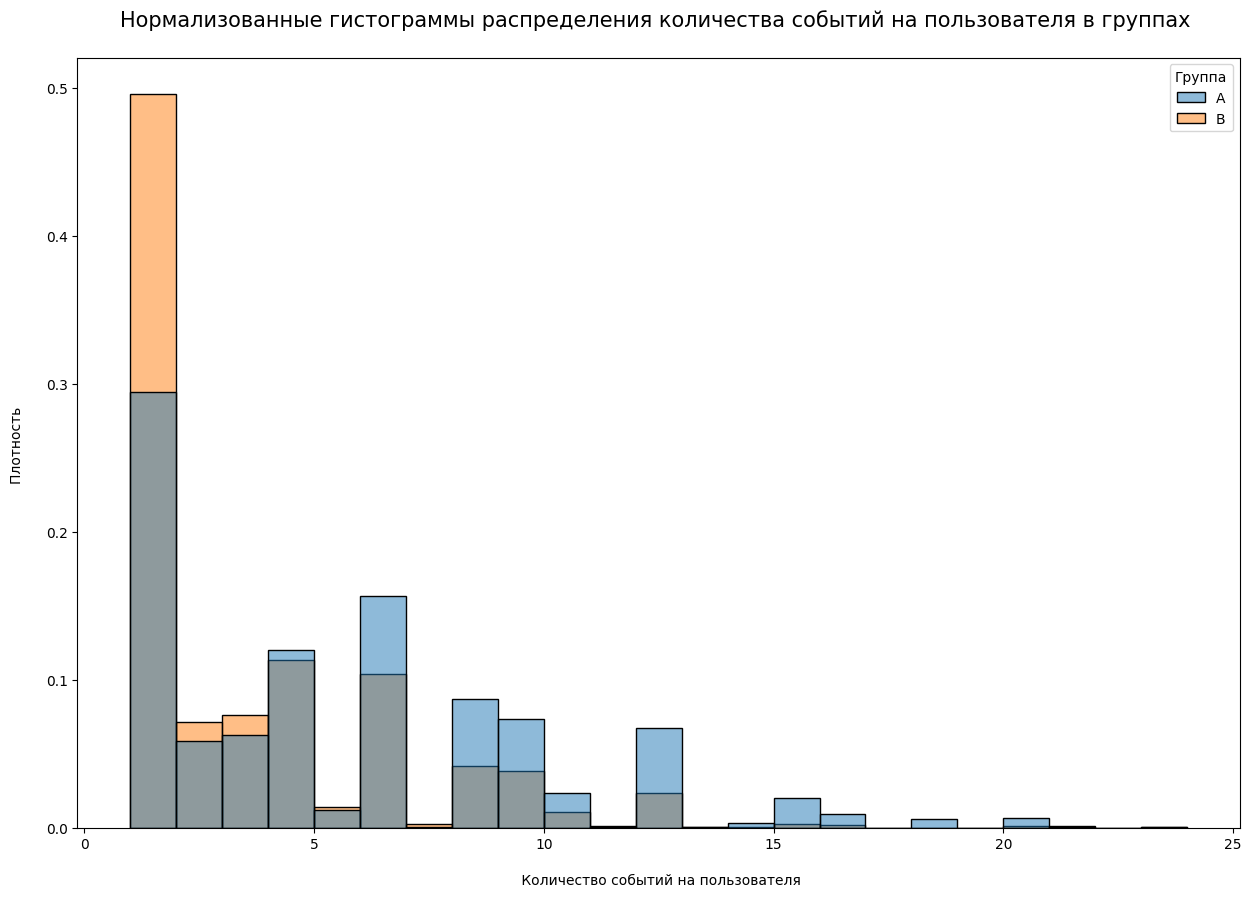

In [101]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes()

sns.histplot(
    data=events_by_users,
    x="Количество событий",
    hue="Группа",
    stat="density",
    common_norm=False,
    binwidth=1,
)
ax.set_title(
    "Нормализованные гистограммы распределения количества событий на пользователя в группах \n"
)
ax.set_xlabel("\n Количество событий на пользователя")
ax.set_ylabel("Плотность \n")
plt.rc("font", size=15)

plt.show()

В группе B наблюдается намного чаще наблюдается 1 событие на пользователя. В группе A чаще наблюдается, чем в группе B, число событий от 4 и более. За счёт этих различий среднее количество событий на пользователя в группе B меньше на 2 события, чем в группе A.

- Как число событий в выборках распределено по дням?

In [102]:
all_data_recom.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date,days_diff
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,0 days 14:43:27
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,0 days 14:43:29
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07,0 days 14:43:27
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN,2020-12-07,0 days 14:43:27
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN,2020-12-20,0 days 15:46:06


In [103]:
events_by_day = all_data_recom.pivot_table(
    index="group", values="event_date", aggfunc=["count", "nunique"]
).reset_index()
events_by_day.columns = ["Группа", "Количество событий", "Количество дней"]
events_by_day["Среднее количество событий в день"] = round(
    events_by_day["Количество событий"] / events_by_day["Количество дней"], 2
)
events_by_day["Количество пользователей"] = events_by_user["Количество пользователей"]
events_by_day["Среднее количество событий в день на 1 пользователя"] = round(
    events_by_day["Среднее количество событий в день"]
    / events_by_day["Количество пользователей"],
    2,
)
events_by_day

,Группа,Количество событий,Количество дней,Среднее количество событий в день,Количество пользователей,Среднее количество событий в день на 1 пользователя
0,A,16692,23,725.74,3385,0.21
1,B,4393,23,191.00,1582,0.12


Количество событий в день сильно отличается между группами: в группе A, в среднем, пользователи совершали 809 событий в день, а в группе B - 229 событий в день. Такое сильно расхождение, скорее всего, связано с различным числом пользователей в группах (в группе A почти в 3 раза больше). Действительно, отличие среднего количества событий в день 1 пользователя отличается между группами на 20%.

Посмотрим на распределение числа событий по дням в обеих группах (построим нормализованные гистограммы распределения, так как количество пользователей в группах значительно отличается):

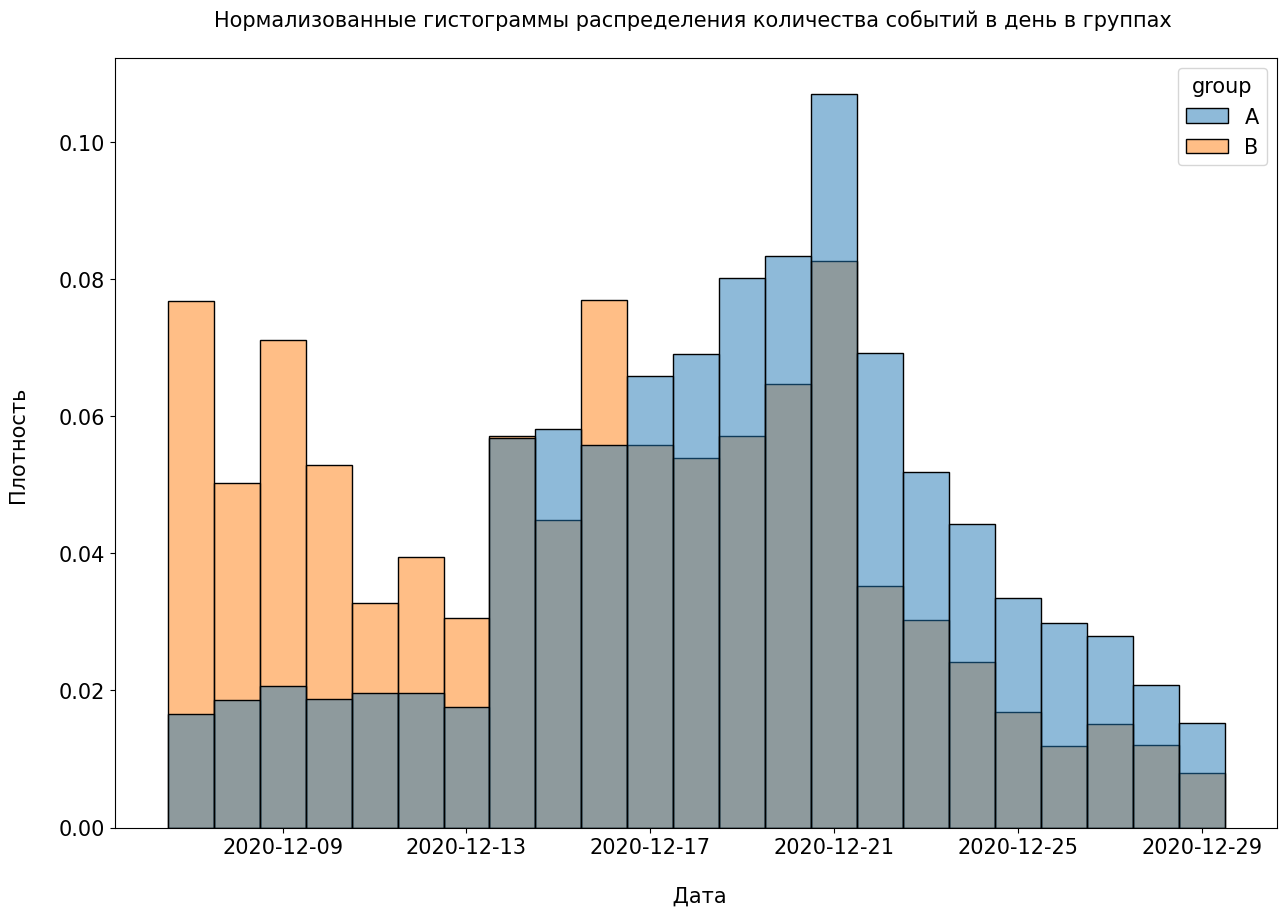

In [104]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes()

sns.histplot(
    data=all_data_recom.query("~event_date.isna()"),
    x="event_date",
    hue="group",
    stat="density",
    common_norm=False,
    binwidth=1,
)
ax.set_title(
    "Нормализованные гистограммы распределения количества событий в день в группах \n"
)
ax.set_xlabel("\n Дата")
ax.set_ylabel("Плотность \n")
plt.rc("font", size=10)

plt.show()

В группе A чаще события происходили, чем в группе B в период с `2020-12-14` по `2020-12-24` (кроме `2020-12-16`).     
В группе B чаще события происходили, чем в группе A в период с `2020-12-07` по `2020-12-23`.

Таким образом, пользователи группы B становится более активными, чем пользоватеми группы A, с 8 дня после регистрации.

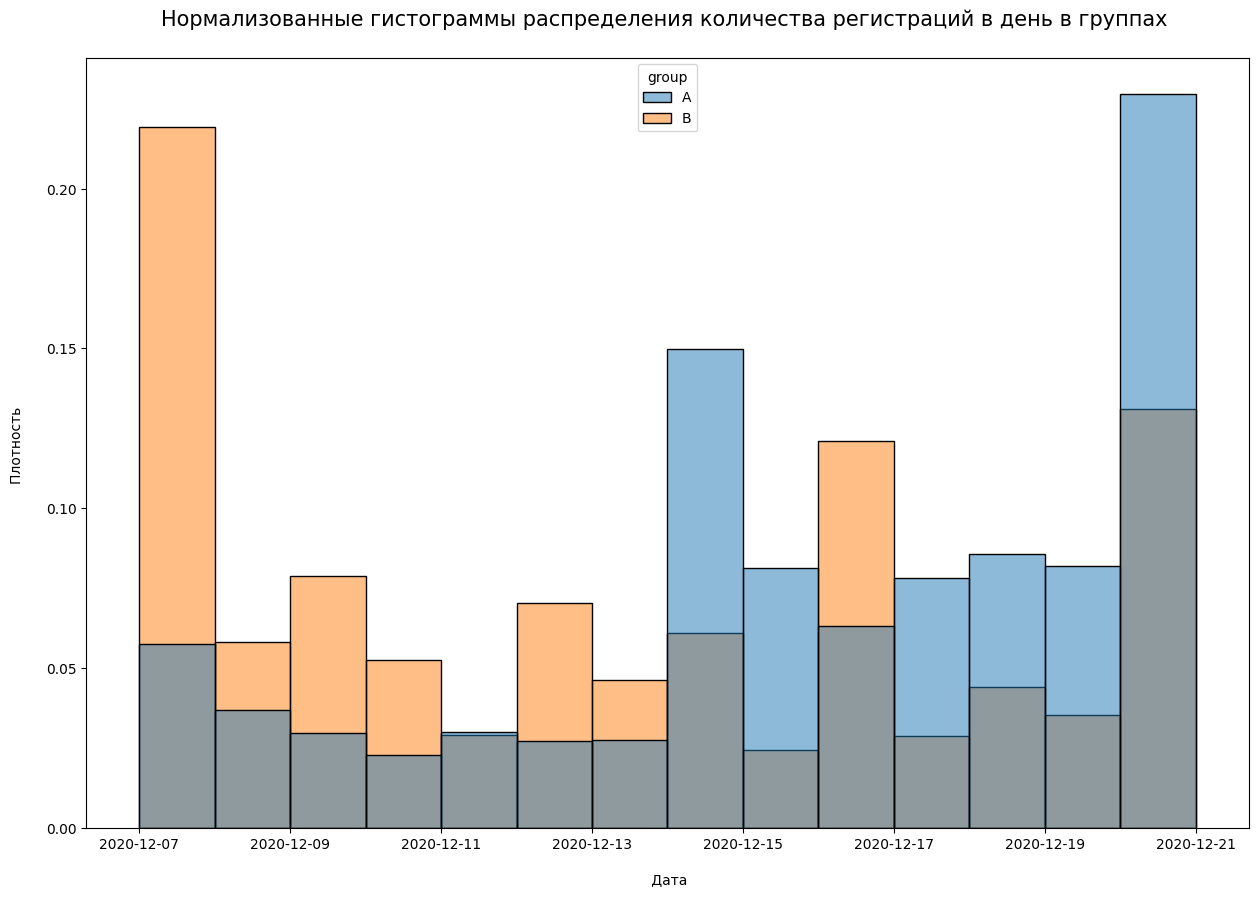

In [105]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes()

sns.histplot(
    data=all_data_recom,
    x="first_date",
    hue="group",
    stat="density",
    common_norm=False,
    binwidth=1,
)
ax.set_title(
    "Нормализованные гистограммы распределения количества регистраций в день в группах \n"
)
ax.set_xlabel("\n Дата")
ax.set_ylabel("Плотность \n")
plt.rc("font", size=10)

plt.show()

Стоит отметить, что в выборке наблюдается ежедневное неравномерное распределение регистрирующихся пользователей по группам. Так, в первые дни теста новые пользователи чаще попадали в группу B, а во второй половине периода теста - в группу A. Ранее мы уже отметили, что у пользователей, зарегистрировавшихся, начиная с `2020-12-12`, неполные данные о событиях (не за 14 дней, а за меньшее число дней) - такие пользователи преимущественно из группы A.
Также неравномерное распределение пользователей по группам в рамках периода исследования может повлиять на результаты, так как пользователи, привлеченные в определенные дни, могли быть более активными (перед праздником), а они были отнесены преимущественно к одной группе.

- Как меняется конверсия в воронке в выборках на разных этапах?

Посчитаем конверсию уникальных пользователей по группам.

In [106]:
conver = all_data_recom.pivot_table(
    index="event_name", columns="group", values="user_id", aggfunc="nunique"
).reset_index()
conver.columns = ["event", "unique_users_A", "unique_users_B"]
conver["event number"] = [1, 3, 2, 4]
conver = conver.sort_values("event number")

conver["next_step_share_A"] = round(
    conver["unique_users_A"] / conver["unique_users_A"].shift(1), 2
)

conver["next_step_share_B"] = round(
    conver["unique_users_B"] / conver["unique_users_B"].shift(1), 2
)

conver.loc[0, "next_step_share_A"] = 1
conver.loc[0, "next_step_share_B"] = 1

conver["first_step_share_A"] = round(
    conver["unique_users_A"] / conver.loc[0, "unique_users_A"], 2
)

conver["first_step_share_B"] = round(
    conver["unique_users_B"] / conver.loc[0, "unique_users_B"], 2
)

conver["diff"] = (
    (conver["first_step_share_B"] / conver["first_step_share_A"]) - 1
).map(lambda x: "{0:.0%}".format(x))

conver

,event,unique_users_A,unique_users_B,event number,next_step_share_A,next_step_share_B,first_step_share_A,first_step_share_B,diff
0,login,2422,821,1,1.00,1.00,1.00,1.00,0%
2,product_page,1571,459,2,0.65,0.56,0.65,0.56,-14%
1,product_cart,728,225,3,0.46,0.49,0.30,0.27,-10%
3,purchase,773,226,4,1.06,1.00,0.32,0.28,-12%


In [107]:
fig = go.Figure()

fig.add_trace(
    go.Funnel(
        name="A",
        y=conver["event"],
        x=conver["unique_users_A"],
        textinfo="value+percent initial",
    )
)

fig.add_trace(
    go.Funnel(
        name="B",
        orientation="h",
        y=conver["event"],
        x=conver["unique_users_B"],
        textposition="inside",
        textinfo="value+percent initial",
    )
)

fig.update_layout(
    title="Воронка событий групп А и B (уникальные пользователи)",
    yaxis_title="Название события",
    legend_title="Группа",
)

fig.show()

Больше всего пользователей теряется при переходе на этап просмотра карточки товара `product_page`. Этот вывод актуален для обеих тестовых групп, но для группы B результат даже хуче, чем для группы A.
Интересно, что на последнем шаге покупки `purchase` уникальных клиентов больше, чем на предыдущем (просмотр корзины `product card`). Скорее всего, есть способ приобрести товар, не проходя этап просмотра корзины (или даже предыдущие).

В группе B результаты хуже, чем в группе A на всех исследуемых воронки. За 14 дней с момента регистрации пользователи группы B не только не показали улучшение каждой метрики не менее, чем на 10%, но и ухудшили.

- Какие особенности данных нужно учесть, прежде чем приступать к A/B- тестированию?

1. Пользователи не должны одновременно относиться к нескольких тестам/группам. Различие ключевых метрик по группам не должно превышать 1% и не должно иметь статистической значимость. Для проверки системы распределения поможет проведение A/A теста.
2. Количество пользователей в различных группах не должно различаться более, чем на 1%.
3. Не следуетт проводить несколько А/В тестов параллельно. Для того, чтобы точно понимать какое изменение повлияло на целевые метрики, лучше не проводить параллельных тестов.
4. Необходимо заранее определить длительность эксперимента.
5. Выбрать период проведения теста, в который не проводятся активности, которые могут повлиять на результаты, а также не наблюдается аномальное поведение пользователей.

## Оценка результатов A/B тестирования
[`Перейти к содержанию проекта`](#beginning)

- Что можно сказать про результаты A/В-тестирования?

В результате исследования мы выявили множество нарушений проведения A/B теста, поэтому результаты могут быть недостоверны. Рекоммендуется провести новый тест, учитывая следующие моменты:
- проверить систему распределения пользователей по тестам (проверить корректность распределения поможет A/A тест) или же лучше не проводить параллельно конкурирующих тестов;
- собрать данные за заранее определенный период (события для каждого пользователя в течение 14 дней после регитсрации);
- собрать заранее определенное необходимое число релеватных участников;
- в идеале выбрать период проведения теста, в который не проводятся маркетинговые активности, которые могут повлиять на результаты, а также не наблюдается аномальное поведение пользователей (как, например, в праздники);

- Проверка статистической разницу долей z-критерием

Проверим гипотезу о равенстве долей уникальных пользователей на каждом этапе воронки между группами A и B. Применим поправку Бонферрони: из-за того, что будем проверять 3 гипотезы, разделим заданный уровень значимости `alpha` на 3.

Сформулированные гипотезы:    
**Нулевая гипотеза H0:** доля уникальных посетителей на данном этапе воронки равна между группами A и B     
**Нулевая гипотеза H1:** доля уникальных посетителей на данном этапе воронки не равна между группами A и B

In [108]:
conver

,event,unique_users_A,unique_users_B,event number,next_step_share_A,next_step_share_B,first_step_share_A,first_step_share_B,diff
0,login,2422,821,1,1.00,1.00,1.00,1.00,0%
2,product_page,1571,459,2,0.65,0.56,0.65,0.56,-14%
1,product_cart,728,225,3,0.46,0.49,0.30,0.27,-10%
3,purchase,773,226,4,1.06,1.00,0.32,0.28,-12%


In [109]:
def z_test(event_A, event_B, group_A, group_B, alpha):
    count = np.array([event_A, event_B])
    nobs = np.array([group_A, group_B])

    stat, p_value = proportions_ztest(count, nobs)
    print(count, nobs)

    print(f"p-значение: {p_value:0.6f}")

    if p_value < alpha:
        return print(
            "Отвергаем нулевую гипотезу, есть значимая разница между долями уникальных пользователей"
        )
    else:
        return print(
            "Нулевая гипотеза не отвергается, нет оснований считать доли разными"
        )

In [110]:
alpha = 0.05
events = ["product_page", "product_cart", "purchase"]

for event in events:
    print("Этап воронки: ", event)
    z_test(
        int(conver.query("event==@event")["unique_users_A"]),
        int(conver.query("event==@event")["unique_users_B"]),
        int(conver.query('event=="login"')["unique_users_A"]),
        int(conver.query('event=="login"')["unique_users_B"]),
        alpha / len(events),
    )
    print("")

Этап воронки:  product_page
[1571  459] [2422  821]
p-значение: 0.000005
Отвергаем нулевую гипотезу, есть значимая разница между долями уникальных пользователей

Этап воронки:  product_cart
[728 225] [2422  821]
p-значение: 0.149388
Нулевая гипотеза не отвергается, нет оснований считать доли разными

Этап воронки:  purchase
[773 226] [2422  821]
p-значение: 0.018590
Нулевая гипотеза не отвергается, нет оснований считать доли разными



Таким образом, подтверждается наличие значимой разницы между долями уникальных пользователей только на этапе перехода к просмотру карточек товара `product_page`.

## Общий вывод
[`Перейти к содержанию проекта`](#beginning)

**Тест был проведен с множеством нарушений.** Вследствие описанных ниже факторов количество участников теста значительно меньше ожидаемого (4967 вместо 6000 ожидаемых). Также наблюдается неравное распределения по группам: в контрольной группе в 2 раза больше пользователей, чем в группе B, и только 11% новых пользователей из EU отобрано в тест:
- **Данные о событиях пользователей предоставлены неполные**: только за период по `2020-12-30` (в этот день тоже, скорее всего, данные неполные) вместо указанного в техническом задании периода по `2020-01-04`;
- Было выявлено **некорректное распределение пользователей между конкурирующими тестами** (1602 пользователя, которые одновременно относятся к 2 разным тестам). При этом, для корректного проведения теста пришлось исключить пользователей, которые находились в группе B конкурирующего теста (783 пользователя), так как изменения, внесенные в рамках другого теста, могли повлиять на поведение пользователей исследуемого теста.
- Из датафрейма были удалены все действия, которые были совершены позже, чем через 14 дней после регистрации, так как, согласно техническому заданию, нас интересует эффект, который покажут пользователи за 14 дней с момента регистрации.
- Было выявлено 2674 участников теста, которые не совершали ни одного действия после регистрации. Скорее всего, произошла какая-то техническая ошибка в период с `2020-12-14` с `2020-12-21`, так как все неактивные далее пользователи в этот период были распределены в группу B. Для корректности результатов исследования из датафрейма были удалены данные о неактивных далее пользователях, зарегистрированных с `2020-12-14`.
- Из-за изначально неполных данных (событиях пользователей только до `2020-12-30`, а не до `2020-01-04`, как описано в тех.задании), в данных есть пользователи, для которых представлена информация о событиях за период менее, чем за 14 дней после регистрации (1465 клиентов). Если их удалить из датафрейма, то останется совсем мало участников теста для дальнейшего анализа. Пользователи не были исключены из исследовани, но стоит отметить, что неполная информация может повлиять на результаты исследования. 

Дополнительно стоит отметить, что время проведения теста совпадает с маркетинговыми и другими активностями:
- на поведение пользователей теста могли повлиять маркетинговые активности (в большей степени 1 активность: `Christmas&New Year Promo`), однако, эти активности одинаково повлияют на две группы (и на A, и на B). Наличие пересекающихся активностей и времени проведения теста нужно учитывать при изучении абсолютных данных, но на относительную конверсию группы В к группе А - не будут иметь воздействие. Поэтому не будем удалять данные за какой-либо период, чтобы исключить влияние событий и праздников.
- в целом, стоит учитывать, что время проведения теста - пора перед Рождественскими и новогодними праздниками, когда поведение клиентов сильно меняется и, как правило, повышается потребительский спрос. Выявленное увеличение активности участников теста в период `2020-12-14` по `2020-12-21` как раз может быть связано с наступающим католическим Рождеством.

**Вышеперечисленные факторы могут исказить результаты тестирования, поэтому для получения более достоверных результатов рекоммендется провести новый тест**, учитывая следующие моменты:
- проверить систему распределения пользователей по тестам (проверить корректность распределения поможет A/A тест) или же лучше не проводить параллельно конкурирующих тестов;
- собрать данные за заранее определенный период (события для каждого пользователя в течение 14 дней после регитсрации);
- собрать заранее определенное необходимое число релеватных участников


**Ожидаемый эффект от внедрения новой рекоммендательной системы не достигнут:**
- В группе B результаты хуже, чем в группе A на всех исследуемых воронки. За 14 дней с момента регистрации пользователи группы B не только не показали улучшение каждой метрики не менее, чем на 10%, но и ухудшили. Больше всего пользователей теряется при переходе на этап просмотра карточки товара `product_page`, что актуально для обеих тестовых групп.
- Статистический критерий подтверждает наличие значимой разницы между долями уникальных пользователей только на этапе перехода к просмотру карточек товара `product_page`.